# Hydrogen Atom

In this notebook we will perform 3D finite difference calculations for an atomic simulation.
We will solve the eigenvalue equation $(-\frac{\Delta}{2} - \frac{1}{|r|}) \Psi = E \Psi$, 
which defines the time independent simulation of a hydrogen atom.

In [1]:
from copy import deepcopy
import numpy as np
from trainsum.numpy import trainsum as ts
from trainsum.typing import UniformGrid, TensorTrain
import matplotlib.pyplot as plt
from string import ascii_lowercase

def get_coords_idxs(grid: UniformGrid, idx: int):
    """Get a 1D-slice of the grid in real coordinated and indices."""
    ndim = len(grid.dims)
    idxs = np.zeros((ndim, grid.dims[idx].size()), dtype=ts.index_type)
    for i in range(ndim):
        if i == idx:
            idxs[i] = np.arange(grid.dims[idx].size())
        else:
            idxs[i] = grid.dims[i].size()//2
    coords = grid.to_coords(idxs)[idx]
    return coords, idxs

# set global cross options for max_rank = 50 for function construction
cross_opts = ts.cross(max_rank=50, eps=1e-10)
ts.set_options(cross_opts)

First we define a utility function for calculating the coordinates and slices of a uniform grid instance.
We also set the global options for cross interpolation related algorithms.

In [2]:
# define the domain on which the problem is solved
ndim = 3
shape = ts.trainshape(2**10, 2**10, 2**10)
domains = [ts.domain(-20, 20) for _ in range(ndim)]
grid = ts.uniform_grid(shape.dims, domains)

In this cell we define the overall settings. We will work in three dimensions with 1024
points in each direction. The intervals are from -20 to 20 Bohr Radii.

In [3]:
def laplace(grid: UniformGrid, idx: int) -> TensorTrain[NDArray]:
    """
    Get the tensor train which represents the finite difference
    laplace operator with the dimension defined by idx.
    """
    train = None
    with ts.exact():
        for i, dim in enumerate(grid.dims):
            if i == idx:
                tmp  = -2.0 * ts.shift(dim, 0) # rank=1
                tmp +=  1.0 * ts.shift(dim, -1) # rank=2
                tmp +=  1.0 * ts.shift(dim, 1) # rank=2
                tmp *= -0.5 / grid.spacings[0]**2
            else:
                tmp = ts.shift(dim, 0) # is the identity
            if train is None:
                train = tmp
            else:
                train.extend(tmp)
    return train

# create the Laplace operators for each direction (x, y, z)
laplace_ops = [laplace(grid, i) for i in range(ndim)]

Before we can solve the equation we need to define all operators. Here we define the finite difference
Laplace operator, which (for a single dimension) represents a tridiagonal Toeplitz matrix with -2 on the main
diagonal and 1 on the diagonals above and below. For multiple dimensions it is the outer product of this
Toeplitz matrix and the identities in the other directions (done here via the extend).

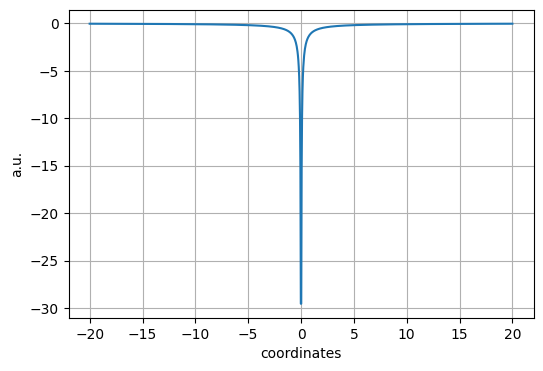

In [4]:
# create the -1/r potential of the hydrogen nucleus
pot_func = lambda idxs: -1.0/np.sqrt(np.sum(grid.to_coords(idxs)**2, axis=0))
pot = ts.tensortrain(shape, pot_func)

# plot a slice
plt.figure(figsize=(6,4))
coords, idxs = get_coords_idxs(grid, 0)
plt.plot(coords, pot[idxs])
plt.xlabel("coordinates")
plt.ylabel("a.u.")
plt.grid()
plt.show()

Having defined the Laplace operator we need to get the $\frac{1}{|r|}$ potential. This
is simply done by using the cross interpolation.

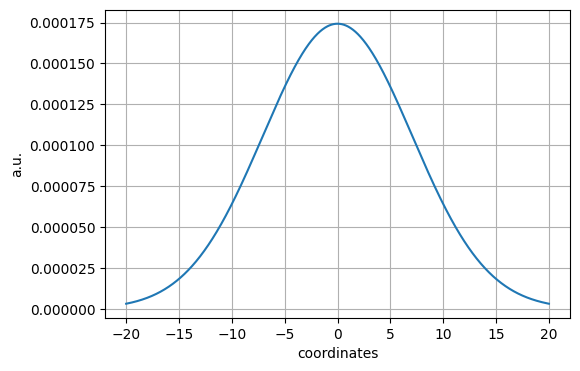

In [5]:
# create a start guess as a Gaussian shaped function
gauss_func = lambda idxs: np.exp(-0.01*np.sum(grid.to_coords(idxs)**2, axis=0))
guess = ts.tensortrain(shape, gauss_func)

# normalize the tensor train
norm = ts.einsum_expression("ijk,ijk->", shape, shape)
guess /= np.sqrt(np.asarray(norm(guess, guess)))

# plot a slice
plt.figure(figsize=(6,4))
coords, idxs = get_coords_idxs(grid, 0)
plt.plot(coords, guess[idxs])
plt.xlabel("coordinates")
plt.ylabel("a.u.")
plt.grid()
plt.show()

The last thing before we can start defining the solver is the definition of an initial guess.
Here we sample a gaussian-shaped function.

In [6]:
# define the linear maps which act as the operator for the problem
laplace_maps = [ts.linear_map("imjnko,mno->ijk", op, guess.shape) for op in laplace_ops]
pot_map = ts.linear_map("mno,mno->mno", pot, guess.shape)

# define a strategy and a lanczos solver to solve the local problems
strat = ts.sweeping_strategy(ncores=2, nsweeps=10)
lanczos_solver = ts.lanczos(nsteps=5, subspace=25, eps=1e-10)

# define the tensorized eigenvalue solver
eig_solver = ts.eigsolver(
    *laplace_maps, pot_map,
    strategy=strat,
    eps=1e-10)

Having fully defined our equation it is time to define the solver. For doing so
we must provide the linear maps via einsum equations.

In [7]:
# callback for printing and retrieval of local results
vals = []
def callback(local_range, local_result):
    print(local_result.value, end="\r", flush=True)
    vals.append(local_result.value)
    return False

# solve the equation with rank=5
eig_solver.decomposition = ts.svdecomposition(max_rank=15, cutoff=1e-15)
guess = eig_solver(guess, callback=callback)
print()

# solve the equation with rank=10
eig_solver.decomposition = ts.svdecomposition(max_rank=10, cutoff=1e-15)
guess = eig_solver(guess, callback=callback)
print()

# solve the equation with rank=15
eig_solver.decomposition = ts.svdecomposition(max_rank=20, cutoff=1e-15)
guess = eig_solver(guess, callback=callback)
print()

-0.49239050677424277
-0.49923885657076283
-0.49969803852571487


Now we can run the algorithm. For DMRG solver it is often useful to start with a low rank and
increase the rank step by step. The correct solution would be 0.5. Due to the discretization error
it is not reached.

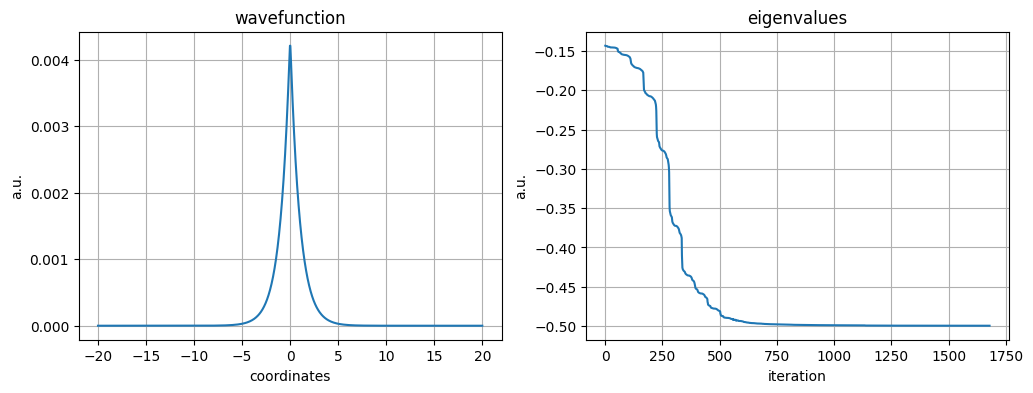

In [8]:
# plot some results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
coords, idxs = get_coords_idxs(grid, 0)
ax[0].plot(coords, guess[idxs])
ax[0].set_xlabel("coordinates")
ax[0].set_ylabel("a.u.")
ax[0].set_title("wavefunction")
ax[0].grid()

ax[1].plot(vals)
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("a.u.")
ax[1].set_title("eigenvalues")
ax[1].grid()
plt.show()